# Huggingface Audio Dataset Preprocessing


In [1]:
from datasets import (
    load_dataset,
    Audio
)
import gradio as gr
import librosa
import matplotlib.pyplot as plt
import numpy as np

from transformers import WhisperFeatureExtractor

# Dataset (Minds14)


[MINDS-14](https://huggingface.co/datasets/PolyAI/minds14) contains recordings of people asking an e-banking system questions in several languages and dialects. The dataset contains 654 audio files, each of which is accompanied by a transcription, an English translation, and a label indicating the intent behind the person’s query. The audio column contains the raw audio data. 

## Load the EN-AU subset of the data

In [2]:
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")

# The lang_id is the same (for EN-AU) for all examples. The english_transcription duplicate the transcription 
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)

minds[0]

/home/eml/venv/ml/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


{'path': '/home/eml/.cache/huggingface/datasets/downloads/extracted/8b2f5b596435dc9607ef03217cdf9a387a9107d462ddb8c450ee1b6ee9295c41/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/eml/.cache/huggingface/datasets/downloads/extracted/8b2f5b596435dc9607ef03217cdf9a387a9107d462ddb8c450ee1b6ee9295c41/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

## Labels

In [3]:
print(minds.features["intent_class"])

ClassLabel(names=['abroad', 'address', 'app_error', 'atm_limit', 'balance', 'business_loan', 'card_issues', 'cash_deposit', 'direct_debit', 'freeze', 'high_value_payment', 'joint_account', 'latest_transactions', 'pay_bill'], id=None)


## Utility

In [4]:
id2label = minds.features["intent_class"].int2str

# Resampling

Pretrained models mostly uses a sampling rate of 16 kHz. MINDS-14 dataset is sampled at 8 kHz. Hence, resample at 16 kHz.

In [5]:
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds[0]

{'path': '/home/eml/.cache/huggingface/datasets/downloads/extracted/8b2f5b596435dc9607ef03217cdf9a387a9107d462ddb8c450ee1b6ee9295c41/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/eml/.cache/huggingface/datasets/downloads/extracted/8b2f5b596435dc9607ef03217cdf9a387a9107d462ddb8c450ee1b6ee9295c41/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

---
# Example Record

In [6]:
example = minds[0]
example

{'path': '/home/eml/.cache/huggingface/datasets/downloads/extracted/8b2f5b596435dc9607ef03217cdf9a387a9107d462ddb8c450ee1b6ee9295c41/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/eml/.cache/huggingface/datasets/downloads/extracted/8b2f5b596435dc9607ef03217cdf9a387a9107d462ddb8c450ee1b6ee9295c41/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [7]:
id2label(example["intent_class"])

'pay_bill'

In [8]:
data = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]
label = id2label(example["intent_class"])

In [9]:
print(sampling_rate)

16000


# Remove long duration data

Filter out any examples longer than 20s to prevent out-of-memory errors.

In [10]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [11]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

# Whisper Preprocessing

* [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperFeatureExtractor)

> ( feature_size = 80 sampling_rate = 16000 hop_length = 160 chunk_length = 30 n_fft = 400 padding_value = 0.0 return_attention_mask = False **kwargs )

In [12]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [13]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [15]:
minds = minds.map(prepare_dataset)

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

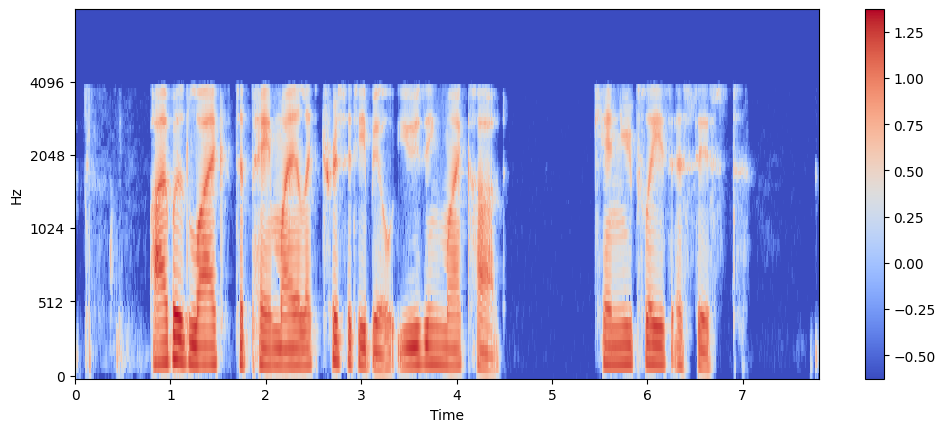

In [16]:
example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()